In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
from torch.utils.data import  DataLoader,random_split
from torchvision import datasets,transforms
import torch.nn as nn
import itertools
import sys
sys.path.append('/content/drive/MyDrive/mask-classfication')


In [4]:
from CustomModel import MaskNet , MaskNetV2
from MaskDataset import MaskImageDataset
import numpy as np

import matplotlib.pyplot as plt
import os
import torch, torchvision


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [5]:
def loadDataset(DATASET_DIR,data_path):
    
    transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])

    full_dataset = MaskImageDataset(data_path, DATASET_DIR, transform=transform)                                   
   
    return DataLoader(full_dataset, batch_size=32, shuffle=True)

In [6]:
CLASSES = ['Cloth-Mask','N95-Mask','N95with Valve-Mask','No-Mask','Surgical-Mask']
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") 

data_path_MALE = "/content/drive/MyDrive/mask-classfication/Male.csv"
data_path_FEMALE = "/content/drive/MyDrive/mask-classfication/Female.csv"
data_path_KIDS = "/content/drive/MyDrive/mask-classfication/Kids.csv"
data_path_MEN = "/content/drive/MyDrive/mask-classfication/Adults.csv"
data_path_ELDERS = "/content/drive/MyDrive/mask-classfication/Elder.csv"

DATASET_MALE = '/content/drive/MyDrive/mask-classfication/Dataset- kfold/Postbias/Gender/Male'
DATASET_FEMALE = '/content/drive/MyDrive/mask-classfication/Dataset- kfold/Postbias/Gender/Female'

DATASET_KIDS = '/content/drive/MyDrive/mask-classfication/Dataset- kfold/Postbias/Age/Kids'
DATASET_MEN = '/content/drive/MyDrive/mask-classfication/Dataset- kfold/Postbias/Age/Adults'
DATASET_ELDERS ='/content/drive/MyDrive/mask-classfication/Dataset- kfold/Postbias/Age/Elder'


In [7]:
from torch.nn.functional import cross_entropy
def test_model(model,test_data,DEVICE):
    #print('RBYRY')  
    testing_loss = 0
    correct_prediction = 0 
    data_size = 0
    prediction1=[]
    #print('RBYRY1')
    #print(test_data)
        
    for images, labels in test_data:
            #print('RBYRY134')
            images = images.to(device)
            labels = labels.to(device)          
            data_size += len(images)
            prediction = model(images)
            
            prediction1.append(prediction)
            
            testing_loss += cross_entropy(prediction, labels).item()
            correct_prediction += (prediction.argmax(dim=1) == labels).sum().item()


    test_accuracy = correct_prediction/data_size
    testing_loss = testing_loss/data_size

    print('\nTesting:')
    print(f"Correct prediction: {correct_prediction}/{data_size} and accuracy: {test_accuracy} and loss: {testing_loss}")
    #print(prediction1)

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
def get_labels_N_prediction(model,loader,DEVICE):
    all_labels = []
    all_prediction = []

    for batch in loader:
        images, labels = batch
        images = images.to(DEVICE)

        prediction = model(images).to(torch.device("cpu")).argmax(dim=1).detach().numpy()
        labels = labels.to(torch.device("cpu")).detach().numpy()

        all_prediction = np.append(all_prediction,prediction)
        all_labels = np.append(all_labels,labels)

    return [all_labels,all_prediction]

  

In [9]:
def display_confusion_matrix(conf_matrix, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(conf_matrix)
    plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = conf_matrix.max() / 2.
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, format(conf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [10]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot
def evaluate(model, DATA,device):
    #print('DVDV')
    test_model(model,DATA,device)
    #print('MALE')
    with torch.no_grad():
        labels_N_prediction = get_labels_N_prediction(model, DATA, device)

    print(classification_report(labels_N_prediction[0], labels_N_prediction[1], target_names =CLASSES))
    conf_matrix = confusion_matrix(labels_N_prediction[0], labels_N_prediction[1])
    plt.figure(figsize=(10, 10))
    display_confusion_matrix(conf_matrix,CLASSES)
    y_pred =labels_N_prediction[1]
    y_test =labels_N_prediction[0]
    disp = PrecisionRecallDisplay(precision=precision_recall_fscore_support(y_test, y_pred)[0],recall=precision_recall_fscore_support(y_test, y_pred)[1])
    disp.plot( marker='.')
    matplotlib.pyplot.show()
    matplotlib.pyplot.savefig('Precision vs Recall.png')

In [11]:
# Loading Model and datasets 
# Copy and paste the model from workspace directory


model = MaskNetV2()
model = model.to(device)
path = F"/content/drive/MyDrive/mask-classfication/saved_models/masknetv2_3_full.pt"
model = torch.load(path,torch.device('cpu'))
''' transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])

full_dataset = MaskImageDataset("/content/drive/MyDrive/mask-classfication/Male.csv", "/content/drive/MyDrive/mask-classfication/Dataset- kfold/Postbias/Gender/Male", transform=transform)

test_data = DataLoader(full_dataset, batch_size=32, shuffle=True)

test_model(model,test_data,device)'''



' transform = transforms.Compose([transforms.Resize((224,224)),\n                                transforms.ToTensor(),\n                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])\n                                ])\n\nfull_dataset = MaskImageDataset("/content/drive/MyDrive/mask-classfication/Male.csv", "/content/drive/MyDrive/mask-classfication/Dataset- kfold/Postbias/Gender/Male", transform=transform)\n\ntest_data = DataLoader(full_dataset, batch_size=32, shuffle=True)\n\ntest_model(model,test_data,device)'

MALE

Testing:
Correct prediction: 22/24 and accuracy: 0.9166666666666666 and loss: 0.007552941019336383
                    precision    recall  f1-score   support

        Cloth-Mask       0.71      1.00      0.83         5
          N95-Mask       1.00      0.75      0.86         4
N95with Valve-Mask       1.00      0.50      0.67         4
           No-Mask       0.86      1.00      0.92         6
     Surgical-Mask       0.80      0.80      0.80         5

          accuracy                           0.83        24
         macro avg       0.87      0.81      0.82        24
      weighted avg       0.86      0.83      0.83        24

Confusion matrix, without normalization
[[5 0 0 0 0]
 [1 3 0 0 0]
 [0 0 2 1 1]
 [0 0 0 6 0]
 [1 0 0 0 4]]


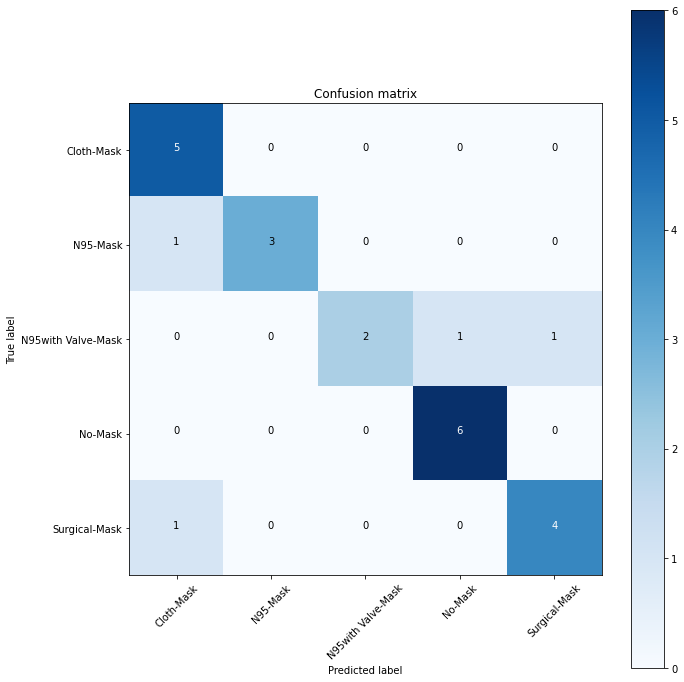

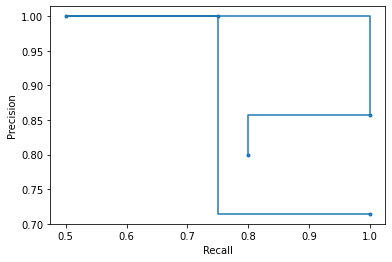

---------------------------
FEMALE

Testing:
Correct prediction: 30/39 and accuracy: 0.7692307692307693 and loss: 0.04608964767211523
                    precision    recall  f1-score   support

        Cloth-Mask       0.89      0.89      0.89         9
          N95-Mask       0.86      0.67      0.75         9
N95with Valve-Mask       0.88      0.88      0.88         8
           No-Mask       1.00      0.86      0.92         7
     Surgical-Mask       0.56      0.83      0.67         6

          accuracy                           0.82        39
         macro avg       0.84      0.82      0.82        39
      weighted avg       0.85      0.82      0.83        39

Confusion matrix, without normalization
[[8 0 0 0 1]
 [0 6 1 0 2]
 [1 0 7 0 0]
 [0 0 0 6 1]
 [0 1 0 0 5]]


<Figure size 432x288 with 0 Axes>

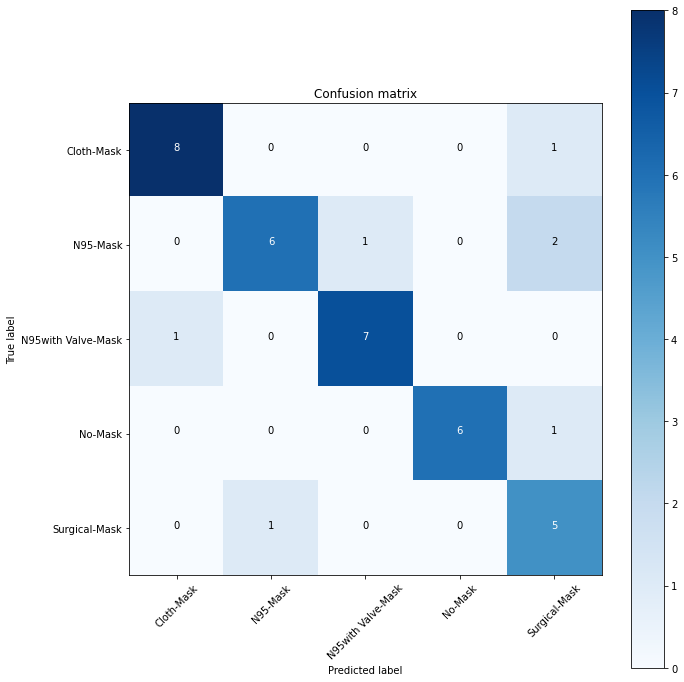

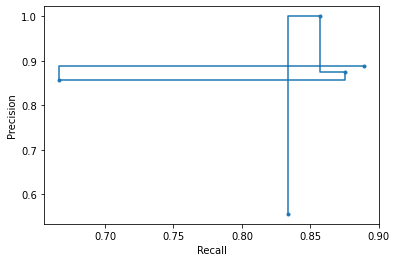

---------------------------
KIDS

Testing:
Correct prediction: 57/60 and accuracy: 0.95 and loss: 0.005239618817965189
                    precision    recall  f1-score   support

        Cloth-Mask       1.00      0.96      0.98        23
          N95-Mask       0.50      1.00      0.67         2
N95with Valve-Mask       1.00      0.83      0.91         6
           No-Mask       1.00      0.96      0.98        25
     Surgical-Mask       0.80      1.00      0.89         4

          accuracy                           0.95        60
         macro avg       0.86      0.95      0.88        60
      weighted avg       0.97      0.95      0.96        60

Confusion matrix, without normalization
[[22  1  0  0  0]
 [ 0  2  0  0  0]
 [ 0  1  5  0  0]
 [ 0  0  0 24  1]
 [ 0  0  0  0  4]]


<Figure size 432x288 with 0 Axes>

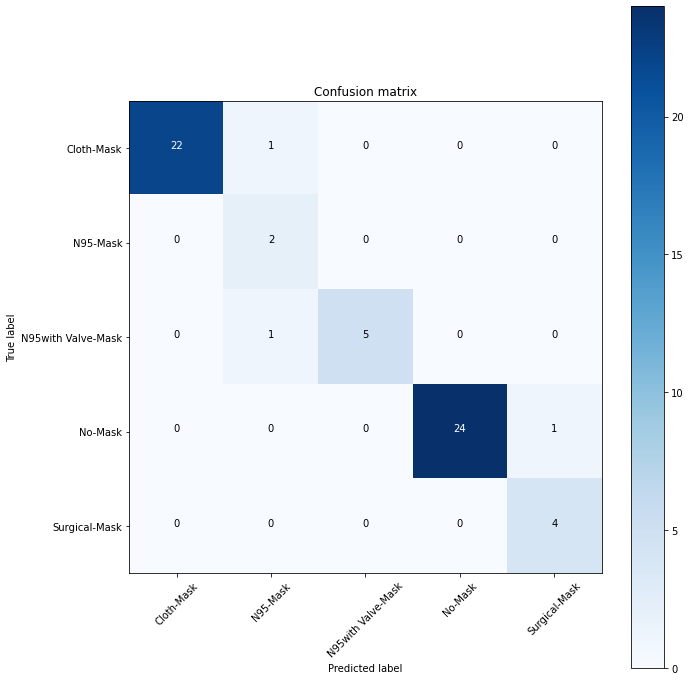

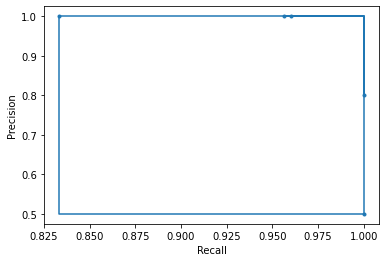

---------------------------
ADULTS

Testing:
Correct prediction: 142/171 and accuracy: 0.8304093567251462 and loss: 0.017888088672481782
                    precision    recall  f1-score   support

        Cloth-Mask       0.81      0.81      0.81        21
          N95-Mask       0.74      0.83      0.78        24
N95with Valve-Mask       0.76      0.88      0.81        25
           No-Mask       0.98      0.95      0.96        56
     Surgical-Mask       0.90      0.80      0.85        45

          accuracy                           0.87       171
         macro avg       0.84      0.85      0.84       171
      weighted avg       0.87      0.87      0.87       171

Confusion matrix, without normalization
[[17  1  2  0  1]
 [ 0 20  2  0  2]
 [ 1  1 22  0  1]
 [ 1  1  1 53  0]
 [ 2  4  2  1 36]]


<Figure size 432x288 with 0 Axes>

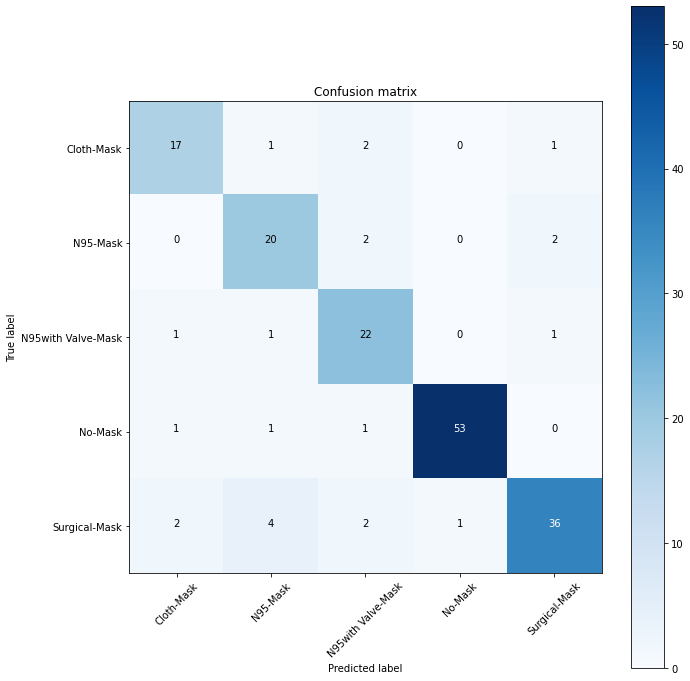

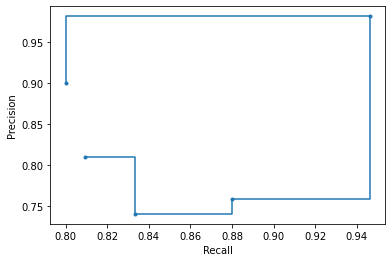

---------------------------
ELDER

Testing:
Correct prediction: 32/37 and accuracy: 0.8648648648648649 and loss: 0.027347190154565347
                    precision    recall  f1-score   support

        Cloth-Mask       0.78      0.78      0.78         9
          N95-Mask       0.67      0.80      0.73         5
N95with Valve-Mask       0.75      1.00      0.86         6
           No-Mask       1.00      0.88      0.93         8
     Surgical-Mask       1.00      0.78      0.88         9

          accuracy                           0.84        37
         macro avg       0.84      0.85      0.83        37
      weighted avg       0.86      0.84      0.84        37

Confusion matrix, without normalization
[[7 1 1 0 0]
 [1 4 0 0 0]
 [0 0 6 0 0]
 [0 1 0 7 0]
 [1 0 1 0 7]]


<Figure size 432x288 with 0 Axes>

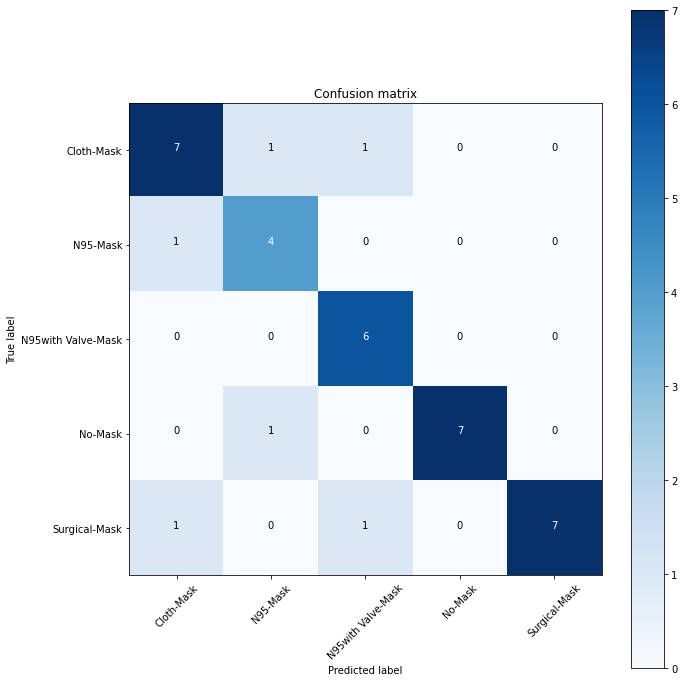

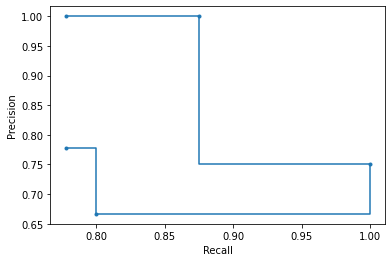

---------------------------


<Figure size 432x288 with 0 Axes>

In [12]:
MALE = loadDataset(DATASET_MALE,data_path_MALE)
FEMALE = loadDataset(DATASET_FEMALE,data_path_FEMALE)
TEEN = loadDataset(DATASET_KIDS,data_path_KIDS)
MEN = loadDataset(DATASET_MEN,data_path_MEN)
OLD = loadDataset(DATASET_ELDERS,data_path_ELDERS)

print('MALE')
evaluate(model, MALE,device)
print('---------------------------')

print('FEMALE')
evaluate(model, FEMALE,device)
print('---------------------------')


print('KIDS')
evaluate(model, TEEN,device)
print('---------------------------')

print('ADULTS')
evaluate(model, MEN,device)
print('---------------------------')

print('ELDER')
evaluate(model, OLD,device)
print('---------------------------')

Prediction : No Mask


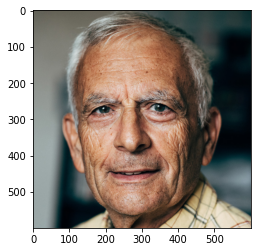

In [13]:
import torch

from torchvision import transforms
from PIL import Image



def predictImage(model, imagePath, device, labels={0:'cloth', 1:'N95', 2:'N95 with valve', 3:'No Mask', 4:'Surgical'}):
    
    
    transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])
    image = Image.open(imagePath).convert('RGB')
    imageD = Image.open(imagePath).convert('RGB')
    
    image = transform(image)
    
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        output = model(image.unsqueeze(0))
    pred = output.argmax(dim=1).cpu().numpy()
    #print(pred)
    
    plt.imshow(imageD)    
    print("Prediction : " + labels[pred[0]])
    
img_path = "/content/drive/MyDrive/mask-classfication/Dataset/NoMask-292.png"

predictImage(model, img_path, "cpu")